# Gas Sensor Array Drift Dataset

### Librerías necesarias

In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import os

### Importamos los datos

In [3]:
path = "data_gasdrift/"
all_files = glob.glob(path + "batch*.DAT")

dfs = []

for file in all_files:
    with open(file, 'r') as f:
        rows = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()[1:]  # ignorar el primer índice
            values = [float(p.split(':')[1]) for p in parts]  # extraer solo el valor
            rows.append(values)
    df = pd.DataFrame(rows)
    dfs.append(df)

# Concatenar todos los archivos
data = pd.concat(dfs, ignore_index=True)

print("Data cargada y limpia:", data.shape)
print("Valores no numéricos restantes:", data.isnull().sum().sum())

Data cargada y limpia: (13910, 128)
Valores no numéricos restantes: 0


### Elegimos la variable target

In [4]:
# Definir sensor objetivo
target = 0  # Sensor 1
y = data.iloc[:, target]       # Variable objetivo
X = data.drop(columns=target)  # Características (el resto de sensores)

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

Shape de X: (13910, 127)
Shape de y: (13910,)


## Análisis exploratorio

**Comprobamos dimensionalidad y valores nulos**

In [5]:
data.info()

# Valores nulos
data.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13910 entries, 0 to 13909
Columns: 128 entries, 0 to 127
dtypes: float64(128)
memory usage: 13.6 MB


0

**Resumen estadístico univariante**

In [6]:
#Convertimos las columnas a numérico
# Convertir todas las columnas a numérico
data_numeric = data.apply(pd.to_numeric, errors='coerce')  # valores no convertibles → NaN

# Revisar si hay valores no numéricos convertidos a NaN
print("Valores no numéricos convertidos a NaN:", data_numeric.isnull().sum().sum())

Valores no numéricos convertidos a NaN: 0


In [7]:
from scipy.stats import skew, kurtosis

stats = pd.DataFrame(index=data.columns)
stats['mean'] = data.mean()
stats['std'] = data.std()
stats['skew'] = data.apply(skew)
stats['kurtosis'] = data.apply(kurtosis)
print(stats)

             mean           std       skew     kurtosis
0    50435.066174  69844.785952   2.544984     9.369244
1        6.638156     13.486391  70.123307  6867.927811
2       12.936688     17.610061   2.335766     7.296383
3       18.743953     24.899450   2.200751     6.207528
4       26.890695     38.107685   4.973343    59.086224
..            ...           ...        ...          ...
123     14.929364     12.437311   2.004278    19.868353
124     19.090980     14.391810   1.490688     3.508195
125     -4.901016      4.195360  -2.085170     7.134971
126     -8.167792      7.637701  -2.737216    11.693023
127    -16.089791     20.958479  -7.363925    81.769185

[128 rows x 4 columns]


· La mayoría de sensores presentan asimetría positiva (skew >0) indicando distribuciones sesgadas hacia valores altos.

· Varias columnas tienen curtosis >3 lo que genera colas pesadas y mayor propensión a outliers. Esto indica que la distribución no es gaussiana y los modelos robustos serán preferibles.

**Visualización de la serie temporal y tendencias**

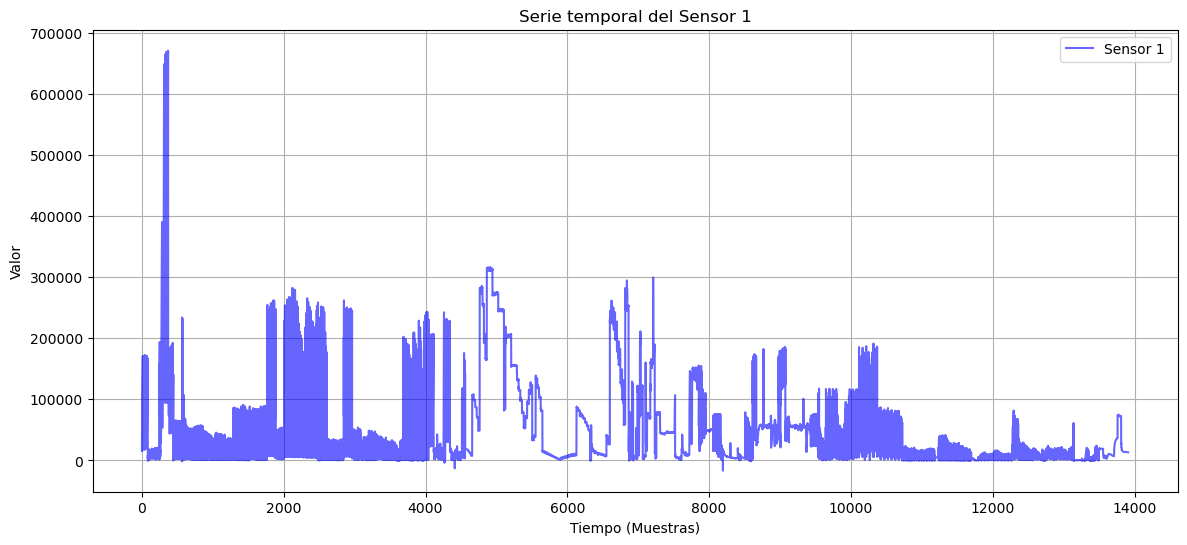

In [14]:
plt.figure(figsize=(14,6))
plt.plot(y.values, color='blue', alpha=0.6, label='Sensor 1')
plt.title("Serie temporal del Sensor 1")
plt.xlabel("Tiempo (Muestras)")
plt.ylabel("Valor")
plt.grid(True)
plt.legend()
plt.show()

La visualización del Sensor 1 muestra una señal caracterizada por una fuerte variabilidad local y una marcada no estacionalidad. A lo largo del eje temporal se observa que el nivel medio de la serie cambia progresivamente, lo que refleja la presencia de drift, fenómeno típico en sensores de gas.

No se aprecia una estacionalidad evidente, ya que la serie no presenta patrones periódicos repetitivos. En su lugar, predominan las fluctuaciones rápidas en torno a valores cambiantes y por la aparición de picos aislados que actúan como outliers. Estos valores atípicos representan exposiciones a concentraciones de gas puntuales.

Desde el punto de vista analítico, este comportamiento supone un desafío para la modelización: los métodos clásicos basados en estacionalidad resultan inadecuados, mientras que modelos autoregresivos o enfoques de ML robustos como LSTM o regresores basados en lags se ajustan mejor a las características de la señal.

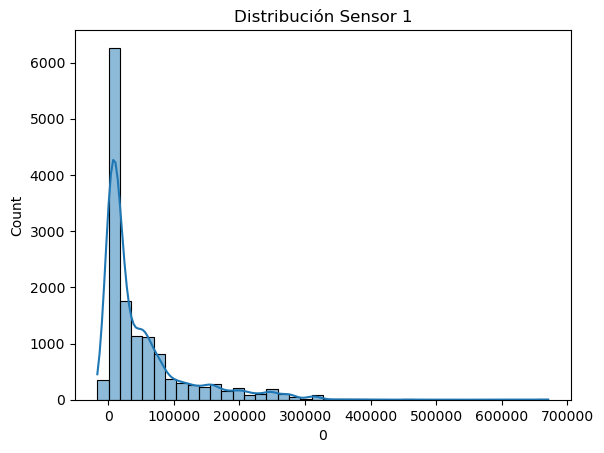

In [9]:
sns.histplot(data.iloc[:,0], kde=True, bins=40)
plt.title("Distribución Sensor 1")
plt.show()

El histograma muestra un sesgo hacia la derecha, lo que indica que la mayoría de las mediciones del sensor son bajas o moderadas, mientras que existen valores ocasionales muy altos. Esto es típico en datos de sensores ambientales, donde la concentración de un gas o partículas suele mantenerse en un rango bajo, pero eventos aislados pueden generar picos.

La curva de densidad (KDE) resalta que hay un valor central predominante, pero con colas largas hacia la derecha, sugiriendo la presencia de eventos extremos o variabilidad significativa. Este patrón indica que cualquier modelo predictivo debería ser capaz de manejar tanto la mayoría de datos concentrados como estos valores extremos, sin asumir normalidad estricta.

Pese a que las visualizaciones paracen indicar con certeza que no existe estacionalidad, es necesario realizar una preuba de no-estacionalidad.

**Preuba de no-estacionalidad**

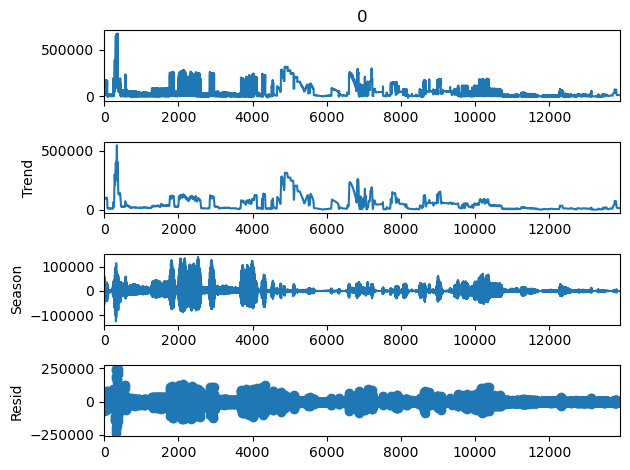

ADF Statistic: -6.711425058776297
p-value: 3.6723524085666575e-09


In [22]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

# Tomamos la serie del Sensor 1
y_sensor = data.iloc[:,0]

# STL
stl = STL(y_sensor.dropna(), period=12)  # period=12 es arbitrario, se puede cambiar
res = stl.fit()
res.plot()
plt.show()

# Prueba ADF
adf_result = adfuller(y_sensor.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

· ADF Statistic negativo y muy bajo: Cuanto más negativo es el estadístico, más evidencia hay contra la hipótesis nula de presencia de raíz unitaria, es decir, que la serie no sea estacionaria.

En este caso, -6.71 es muy bajo, indicando que la serie no tiene raíz unitaria.

· p-value extremadamente bajo: Un p-value de ~0 indica que la probabilidad de que la serie tenga raíz unitaria (no estacionaria) es prácticamente nula.

Se rechaza la hipótesis nula con total confianza (mucho menor que 0.05).

**Outliers (Sensor 1)**

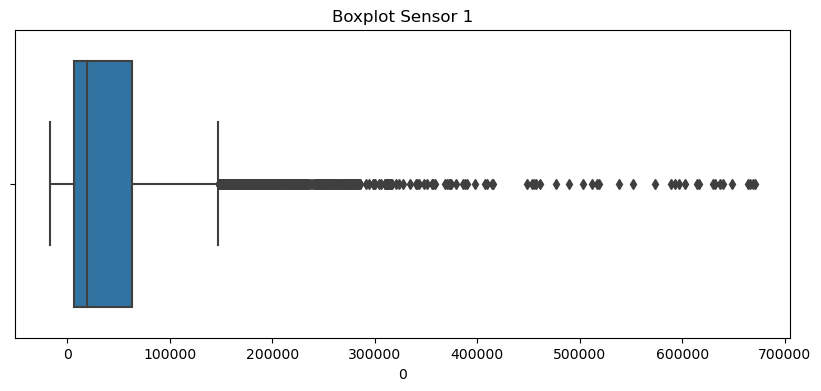

Outliers detectados (Sensor 1): 1418


In [10]:
Q1 = data.iloc[:,0].quantile(0.25)
Q3 = data.iloc[:,0].quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5*IQR
high = Q3 + 1.5*IQR

outliers = data[(data.iloc[:,0] < low) | (data.iloc[:,0] > high)].iloc[:,0]

plt.figure(figsize=(10,4))
sns.boxplot(x=data.iloc[:,0])
plt.title("Boxplot Sensor 1")
plt.show()

print("Outliers detectados (Sensor 1):", len(outliers))

El boxplot revela numerosos outliers por encima del rango intercuartílico, reflejando la presencia de eventos atípicos frecuentes. La detección basada en IQR sugiere que una proporción significativa de datos se encuentra fuera del rango esperado, pero en el contexto de sensores ambientales, estos no necesariamente son errores de medición, sino concentracione spuntuales como hemos dicho antes.

Al tratarse de eventos reales, lo más lógico es mantener los outliers, por lo que algoritmos basados en árboles o modelos robustos a outliers (Random Forest, XGBoost, etc.) son los más adecuados aprovechar los datos tal cual sin necesidad de transformación.

**Correlaciones entre sensores**

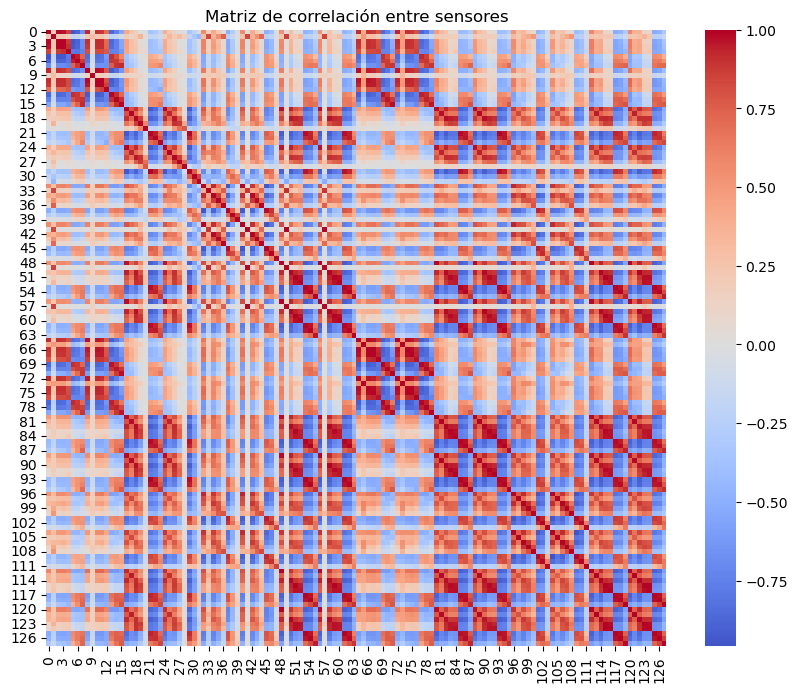

In [11]:
plt.figure(figsize=(10,8))
corr = data.corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de correlación entre sensores")
plt.show()

La matriz de correlación muestra bloques de alta correlación entre algunos sensores, lo que indica redundancia. Esto puede suceder cuando múltiples sensores miden gases o variables relacionadas, o están ubicados en posiciones similares.

Implicaciones:

Reducción de dimensionalidad: Técnicas como PCA pueden ayudar a capturar la mayor parte de la variabilidad con menos componentes, reduciendo ruido y complejidad.

Selección de sensores: Identificar sensores redundantes puede ayudar a simplificar el sistema sin perder información crítica.

Feature engineering: Los componentes principales o combinaciones lineales de sensores correlacionados pueden ser utilizados como variables más representativas para modelos predictivos.

**Autocorrelación del sensor 1**

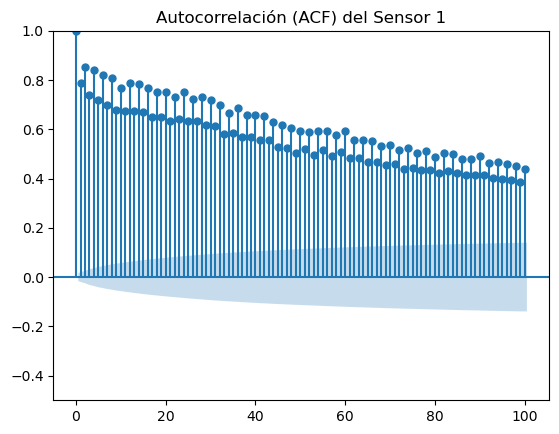

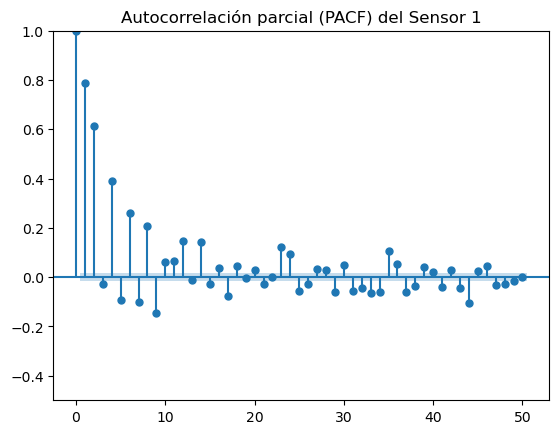

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF
plot_acf(y.dropna(), lags=100)
plt.ylim(-0.5, 1)  # límite inferior hasta -0.50
plt.title("Autocorrelación (ACF) del Sensor 1")
plt.show()

# PACF
plot_pacf(y.dropna(), lags=50)
plt.ylim(-0.5, 1)  # límite inferior hasta -0.50
plt.title("Autocorrelación parcial (PACF) del Sensor 1")
plt.show()

La ACF muestra una decadencia lenta, indicando que los valores pasados influyen en los futuros (dependencia temporal fuerte). La PACF corta rápidamente, lo que sugiere que solo los primeros lags tienen un efecto directo significativo.

**Dimensionalidad**

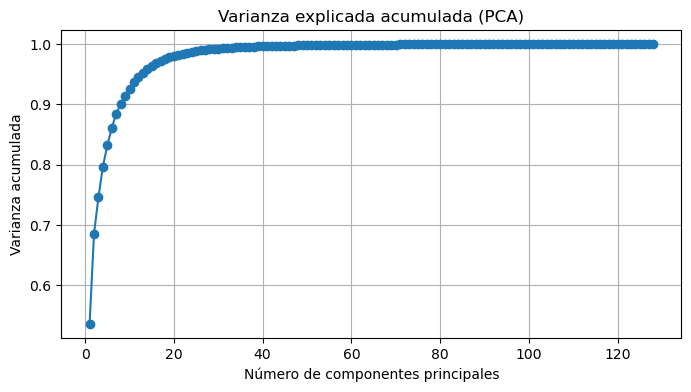

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

pca = PCA().fit(X_scaled)
plt.figure(figsize=(8,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title("Varianza explicada acumulada (PCA)")
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza acumulada")
plt.grid(True)
plt.show()


El PCA muestra que una pequeña cantidad de componentes principales explica la mayor parte de la varianza, confirmando la redundancia observada en la correlación entre sensores. Esto permite reducir dimensionalidad sin perder información crítica, mejorando la eficiencia computacional y la interpretabilidad.
Implicaciones:

· Simplificación de modelos: Entrenar sobre componentes principales puede reducir ruido y mejorar rendimiento.

· Visualización: Los primeros 2–3 componentes principales pueden ofrecer representaciones útiles de patrones generales en los datos.

· Reducción de multicolinealidad: Al combinar sensores correlacionados en componentes principales, se evita la multicolinealidad, útil para modelos lineales.

## Modelado

Dado que a partir del instante de predicción no tenemos valores de regresoras, necesitamos modelos autoregresivos univariantes o basados en la serie objetivo, los elegidos son los siguientes:

· ARIMA: Modelo clásicos de series temporales.

· ML con lags: Random Forest usando solo valores pasados como features.

· RNN / LSTM: Redes neuronales que pueden predecir múltiples pasos hacia adelante usando solo la secuencia histórica. En este caso, LSTM mas favorable ya que tiene memoria tanto a corto como largo plazo.

**Prepra